In [1]:
import opendatasets as od

In [6]:
# Download the dataset from Kaggle
dataset_url="https://www.kaggle.com/datasets/emmarex/plantdisease"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease


100%|██████████| 658M/658M [00:00<00:00, 2.15GB/s]


In [28]:
data_dir="../PlantVillage"

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setup image size and batch size
img_height, img_width = 224, 224
batch_size = 32

# Create an ImageDataGenerator with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training data generator
train_generator = datagen.flow_from_directory(
    directory=data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data generator
val_generator = datagen.flow_from_directory(
    directory=data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


#Visualization of the data

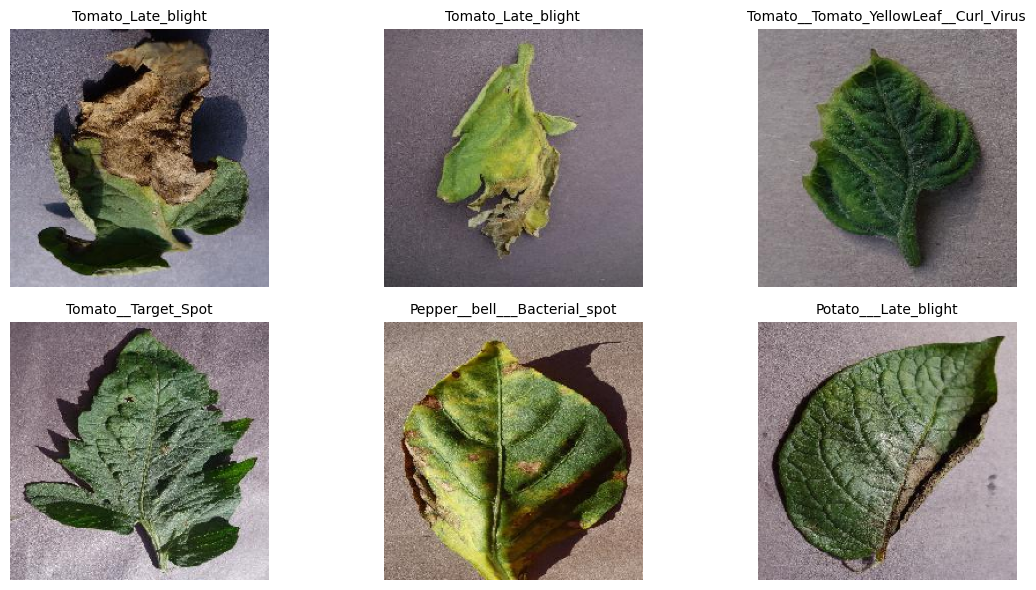

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of images and labels
images, labels = next(train_generator)

# Class labels
class_names = list(train_generator.class_indices.keys())

# Plot 6 images
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    plt.title(class_names[label_index], fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [31]:
# Import and Set Up the Base Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 without the top layer
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 7s 1us/step


In [32]:
# Add a Custom Classification Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)



In [33]:
# Compile the Model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
#Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=
)


Epoch 1/10
  7/517 ━━━━━━━━━━━━━━━━━━━━ 1:44 204ms/step - accuracy: 0.8517 - loss: 0.3997

KeyboardInterrupt: 

In [ ]:
# Plot Accuracy and Loss Over Epochs
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Save the Model for Later Use
model.save('model/plantwise_model.h5')


In [ ]:
# Evaluate on the Validation Set (Optional)
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.2f}")


In [ ]:
# Show a Few Predictions with Images
import numpy as np
from tensorflow.keras.preprocessing import image

images, labels = next(val_generator)

preds = model.predict(images)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(labels, axis=1)

class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[pred_classes[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
